# Kalman Filter and Message passing


Given a Gaussian linear state-space model in the form;
$$
x_k = A_kx_{k-1} + q_{k-1} \\
y_k = H_kx_k + r_k
$$
where $x_k \in \mathbb{R}^{n}$ is the state, $y_k \in \mathbb{R}^{m}$ is the measurement. Process noise and measurement noise are assumed to be zero mean Gaussian with covariance matrices $Q_k$ and $R_k$ respectively. In Bayesian notation this takes the form
$$
p(x_k | x_{k-1}) = \mathcal{N}(x_k|A_kx_{k-1},Q_{k-1})\\
p(y_k | x_k) = \mathcal{N}(y_k|H_kx_k,R_k).
$$
In Lecture 12, tracking of states of the cart with known dynamics was solved through analytic update rules of Kalman Filter. In this notebook we will investigate inference on the same model using ForneyLab. Under the hood ForneyLab constructs factor graphs corresponding to the model user specifies and performs automated inference via message passing. Without further details lets build the state space model and let ForneyLab work out the inference.


In [1]:
using LinearAlgebra, ForneyLab
include("scripts/cart_tracking_helpers.jl") # implements required factor nodes + helper functions

# Specify the model parameters
Δt = 1.0                     # assume the time steps to be equal in size
A = [1.0 Δt;
     0.0 1.0]
b = [0.5*Δt^2; Δt] 
Σz = convert(Matrix,Diagonal([0.2*Δt; 0.1*Δt])) # process noise covariance
Σx = convert(Matrix,Diagonal([1.0; 2.0]))     # observation noise covariance;

# Generate noisy observations
n = 10                # perform 10 timesteps
z_start = [10.0; 2.0] # initial state
u = 0.2 * ones(n)     # constant input u
noisy_x = generateNoisyMeasurements(z_start, u, A, b, Σz, Σx);


┌ Info: Recompiling stale cache file /Users/isenoz/.julia/compiled/v1.0/ForneyLab/Eacon.ji for ForneyLab [9fc3f58a-c2cc-5bff-9419-6a294fefdca9]
└ @ Base loading.jl:1187
┌ Warning: Package ForneyLab does not have FastGaussQuadrature in its dependencies:
│ - If you have ForneyLab checked out for development and have
│   added FastGaussQuadrature as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ForneyLab
└ Loading FastGaussQuadrature into ForneyLab from project dependency, future warnings for ForneyLab are suppressed.
┌ Info: Recompiling stale cache file /Users/isenoz/.julia/compiled/v1.0/Distributions/xILW0.ji for Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1187


# Model Definition with ForneyLab

In [2]:
fg = FactorGraph()
z_prev_m = Variable(id=:z_prev_m); placeholder(z_prev_m, :z_prev_m, dims=(2,))
z_prev_v = Variable(id=:z_prev_v); placeholder(z_prev_v, :z_prev_v, dims=(2,2))
bu = Variable(id=:bu); placeholder(bu, :bu, dims=(2,))

@RV z_prev ~ GaussianMeanVariance(z_prev_m, z_prev_v, id=:z_prev) # p(z_prev)
@RV noise_z ~ GaussianMeanVariance(constant(zeros(2), id=:noise_z_m), constant(Σz, id=:noise_z_v)) # process noise
@RV z = constant(A, id=:A) * z_prev + bu + noise_z; z.id = :z # p(z|z_prev) (state transition model)
@RV x ~ GaussianMeanVariance(z, constant(Σx, id=:Σx)) # p(x|z) (observation model)
placeholder(x, :x, dims=(2,));
ForneyLab.draw(fg)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 7337571719248440259 -->
 
 7337571719248440259 
 
 A 
 
<!-- 16663008976820923847 -->
 
 16663008976820923847 
 
 placeholder_z_prev_m 
 
<!-- 11397895279356993222 -->
 
 11397895279356993222 
 
 + 
 addition_1 
 
<!-- 12402206565250101220 -->
 
 12402206565250101220 
 
 placeholder_bu 
 
<!-- 11397895279356993222--12402206565250101220 -->
 
 11397895279356993222--12402206565250101220 
 
 bu 
 1 out 
 3 in2 
 
<!-- 15333196501159404658 -->
 
 15333196501159404658 
 
 × 
 multiplication_1 
 
<!-- 11397895279356993222--15333196501159404658 -->
 
 11397895279356993222--15333196501159404658 
 
 variable_1 
 1 out 
 2 in1 
 
<!-- 15242295107427373794 -->
 
 15242295107427373794 
 
 noise_z_v 
 
<!-- 17918192173494928134 -->
 
 17918192173494928134 
 
 𝒩 
 gaussianmeanvariance_1 
 
<!-- 17918192173494928134--15242295107427373794 -->
 
 17918192173494928134--15242295107427373794 
 
 noise_z_v 
 1 out 
 3 v 
 
<!-- 850248781511197610 -->
 
 850248781511197610 
 
 noise_z_m 
 
<!-- 17918192173494928134--850248781511197610 -->
 
 17918192173494928134--850248781511197610 
 
 noise_z_m 
 1 out 
 2 m 
 
<!-- 16006227697105635511 -->
 
 16006227697105635511 
 
 𝒩 
 gaussianmeanvariance_2 
 
<!-- 14782500344649956045 -->
 
 14782500344649956045 
 
 Σx 
 
<!-- 16006227697105635511--14782500344649956045 -->
 
 16006227697105635511--14782500344649956045 
 
 Σx 
 1 out 
 3 v 
 
<!-- 6962589179712665815 -->
 
 6962589179712665815 
 
 + 
 addition_2 
 
<!-- 16006227697105635511--6962589179712665815 -->
 
 16006227697105635511--6962589179712665815 
 
 z 
 1 out 
 2 m 
 
<!-- 7690254996988640584 -->
 
 7690254996988640584 
 
 placeholder_z_prev_v 
 
<!-- 16991860219565164624 -->
 
 16991860219565164624 
 
 placeholder_x 
 
<!-- 16991860219565164624--16006227697105635511 -->
 
 16991860219565164624--16006227697105635511 
 
 x 
 1 out 
 1 out 
 
<!-- 6962589179712665815--11397895279356993222 -->
 
 6962589179712665815--11397895279356993222 
 
 variable_2 
 1 out 
 2 in1 
 
<!-- 6962589179712665815--17918192173494928134 -->
 
 6962589179712665815--17918192173494928134 
 
 noise_z 
 1 out 
 3 in2 
 
<!-- 17101055807534223842 -->
 
 17101055807534223842 
 
 𝒩 
 z_prev 
 
<!-- 17101055807534223842--16663008976820923847 -->
 
 17101055807534223842--16663008976820923847 
 
 z_prev_m 
 1 out 
 2 m 
 
<!-- 17101055807534223842--7690254996988640584 -->
 
 17101055807534223842--7690254996988640584 
 
 z_prev_v 
 1 out 
 3 v 
 
<!-- 15333196501159404658--7337571719248440259 -->
 
 15333196501159404658--7337571719248440259 
 
 A 
 1 out 
 3 a 
 
<!-- 15333196501159404658--17101055807534223842 -->
 
 15333196501159404658--17101055807534223842 
 
 z_prev 
 1 out 
 2 in1

# Build an algorithm and infer

𝒩(m=[40.11, 2.56], v=[[1.00, 0.00][0.00, 2.00]])



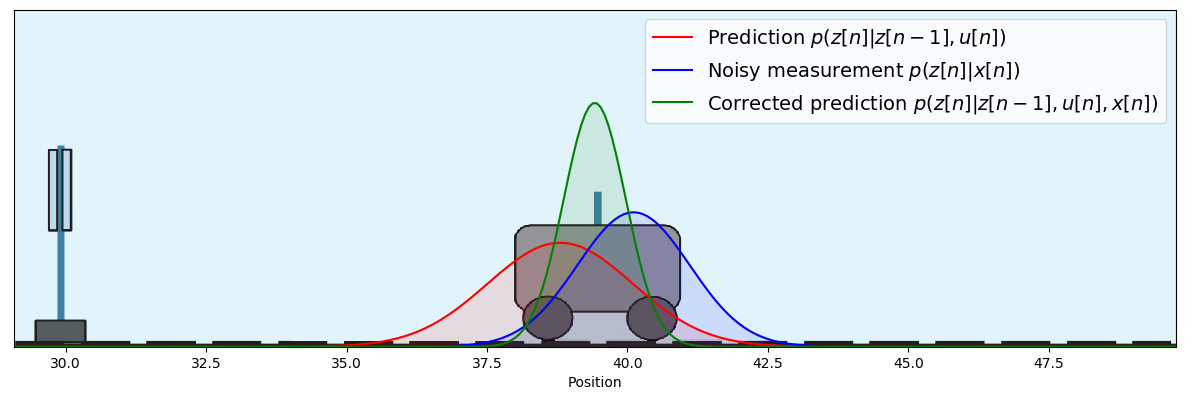

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = plotCartPrediction(::ProbabilityDistribution{Multivariate,GaussianMeanVariance}, ::ProbabilityDistribution{Multivariate,GaussianMeanVariance}, ::ProbabilityDistribution{Multivariate,GaussianMeanVariance}) at cart_tracking_helpers.jl:66
└ @ Main /Users/isenoz/Documents/BMLIP/lessons/notebooks/scripts/cart_tracking_helpers.jl:66
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = plotCartPrediction(::ProbabilityDistribution{Multivariate,GaussianMeanVariance}, ::ProbabilityDistribution{Multivariate,GaussianMeanVariance}, ::ProbabilityDistribution{Multivariate,GaussianMeanVariance}) at cart_tracking_helpers.jl:66
└ @ Main /Users/isenoz/Documents/BMLIP/lessons/notebooks/script

In [3]:
include("scripts/cart_tracking_helpers.jl")
eval(Meta.parse(sumProductAlgorithm(z))) # build message passing algorithm
marginals = Dict()
messages = Array{Message}(undef,6)
z_prev_m_0 = zeros(2)
z_prev_v_0 = 1e8*Diagonal(I,2)
for t=1:n
    data = Dict(:x => noisy_x[t], :bu => b*u[t],:z_prev_m => z_prev_m_0, :z_prev_v => z_prev_v_0)
    step!(data, marginals, messages) # perform msg passing (single timestep)
    # Posterior of z becomes prior of z in the next timestep:
#     ForneyLab.ensureParameters!(marginals[:z], (:m, :v))
    
    z_prev_m_0 = ForneyLab.unsafeMean(marginals[:z])
    z_prev_v_0 = ForneyLab.unsafeCov(marginals[:z])
end
println(messages[6].dist)
# Collect prediction p(z[n]|z[n-1]), measurement p(z[n]|x[n]), corrected prediction p(z[n]|z[n-1],x[n])
prediction      = messages[5].dist # the message index is found by manual inspection of the schedule
measurement     = messages[6].dist
corr_prediction = convert(ProbabilityDistribution{Multivariate, GaussianMeanVariance}, marginals[:z])

# Make a fancy plot of the prediction, noisy measurement, and corrected prediction after n timesteps
plotCartPrediction(prediction, measurement, corr_prediction);